In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from tools.helper import clean_str
import time, os, re

Using TensorFlow backend.


# Create the Dataset

In [2]:
DATA_PATHS = ['/data/2016_sic/ioannis_data/new_data_3/fold0/training.json',
              '/data/2016_sic/ioannis_data/new_data_3/fold0/validation.json',
             ]
data = []
for DATA_PATH in DATA_PATHS:
    with open(DATA_PATH) as json_file:  
        for line in json_file:
            data.append(json.loads(line))

In [3]:
df = pd.DataFrame(data)
df.head()

,class,des,des_class,web,web_class,web_id
0,contradiction,loading and unloading of goods or passengers ...,52241,DVB Bank - Homepage,64929,216475
1,contradiction,manufacture of luggage handbags and the like ...,15120,Independent financial advisors in Lancashire f...,66190,82098
2,entailment,repair of fishing nets including mending repa...,33190,Welcome to A1 Lifts. Professional and reliable...,33190,453844
3,contradiction,preparation and serving of beverages for imme...,56302,Largest choice of tiles in the South West. We ...,46730,690360
4,contradiction,manufacture of felt manufacture of tulles and...,13990,"Leading UK pharmacy services, products, prescr...",47730,337516


In [4]:
df = df[df['class']=='entailment']
df = df.drop(columns = ['class', 'des', 'des_class'])
df = df.drop_duplicates()
df = df.rename(columns = {'web_id':'id','web':'text','web_class':'categories'})
df = df.set_index('id')

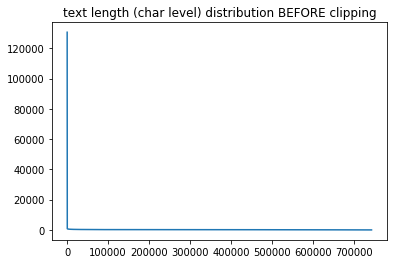

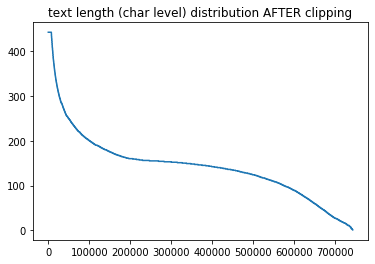

In [5]:
# text length (char level)
tt = df['text'].apply(len)
plt.plot(sorted(tt.values,reverse= True))
plt.title('text length (char level) distribution BEFORE clipping')
plt.show()
q = np.percentile(tt.values,99)
plt.plot(sorted([min(q,t) for t in tt.values],reverse= True))
plt.title('text length (char level) distribution AFTER clipping')
plt.show()

In [6]:
# clip 
def clip_this(s,q):
    if len(s)<=q:
        return s
    ind = s[:q].rfind(' ')
    return s[:ind]
df['text'] = df['text'].apply(lambda x:clip_this(x,int(q)))

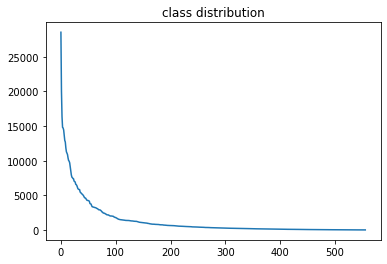

In [7]:
# class distribution
plt.title('class distribution')
plt.plot(sorted(df.categories.value_counts().values,reverse = True))
plt.show()

In [8]:
df['categories'] = df['categories'].apply(lambda x:[x])
df.head()

,text,categories
id,,
453844,Welcome to A1 Lifts. Professional and reliable...,[33190]
914843,"Our friendly service, surprising range of fres...",[47110]
326959,"Wherever you want to get to in life, Lloyds Ba...",[64191]
541943,Stanley Gibbons – The home of stamp collecting...,[47789]
445157,Are you looking for high-quality dentistry in ...,[86230]


In [9]:
cleaned = {}

In [55]:
# clean text
aa = len(df)
start = time.time()
for i,(id,text) in enumerate(df['text'].iteritems()):
    if id in cleaned.keys():
        continue
    cleaned[id] = clean_str(text)
    if i%(aa//10)==0:
        duration = time.time()-start
        print('{:02d}:{:02d}'.format(int(duration//60),int(duration%60)))
        print('COMPLETE {:.0f}% '.format(i/aa*100),end = '')
    elif i%(aa//100)==0:
        print('.',end = '')

In [15]:
df['text'] = df.index.map(cleaned)

### test train split

In [25]:
test_split = 0.2
split = int(len(df)*test_split)
ind = np.arange(len(df))
np.random.seed(0)
np.random.shuffle(ind)
df['train/test']='train'
df.loc[df.index.values[ind[:split]],'train/test']='test'

In [40]:
df['train/test']='train'
df.loc[df.index.values[ind[:split]],'train/test']='test'

In [41]:
df['train/test'].value_counts()

train    588992
test     147247
Name: train/test, dtype: int64

In [48]:
df.head()

,text,categories,train/test
id,,,
453844,welcome to a1 lifts . professional and reliabl...,33190,train
914843,"our friendly service , surprising range of fre...",47110,train
326959,"wherever you want to get to in life , lloyds b...",64191,train
541943,stanley gibbons – the home of stamp collecting...,47789,train
445157,are you looking for high-quality dentistry in ...,86230,train


In [47]:
df.to_pickle('data/sic.pkl')

### save for FastText

In [49]:
df['joined'] = df.apply(lambda x: '__label__' + x['categories'].strip()+' '+x['text'].strip(),axis=1)

In [50]:
df.head()

,text,categories,train/test,joined
id,,,,
453844,welcome to a1 lifts . professional and reliabl...,33190,train,__label__33190 welcome to a1 lifts . professio...
914843,"our friendly service , surprising range of fre...",47110,train,"__label__47110 our friendly service , surprisi..."
326959,"wherever you want to get to in life , lloyds b...",64191,train,__label__64191 wherever you want to get to in ...
541943,stanley gibbons – the home of stamp collecting...,47789,train,__label__47789 stanley gibbons – the home of s...
445157,are you looking for high-quality dentistry in ...,86230,train,__label__86230 are you looking for high-qualit...


In [54]:
np.savetxt('data/FT/sic.test.txt',df[df['train/test']=='test'].joined.values,fmt='%s')
np.savetxt('data/FT/sic.train.txt',df[df['train/test']=='train'].joined.values,fmt='%s')

# GET HIARARCHY

In [104]:
df = pd.read_pickle('data/sic.pkl')
df.head()

,text,categories,train/test
id,,,
453844,welcome to a1 lifts . professional and reliabl...,[33190],train
914843,"our friendly service , surprising range of fre...",[47110],train
326959,"wherever you want to get to in life , lloyds b...",[64191],train
541943,stanley gibbons – the home of stamp collecting...,[47789],train
445157,are you looking for high-quality dentistry in ...,[86230],train


In [105]:
# get num to letter lookup table
DATA_PATH = 'data/sic_hierarchy.json'
with open(DATA_PATH) as json_file:  
    hierarchy = json.load(json_file)
alpha_look = {}
for key,item in hierarchy.items():
    if key[3]!='x' or key[1]=='x':
        continue
    num = key[1:3]
    if num in alpha_look.keys():
        print('repeated key:{}'.format(key))
        break
    alpha_look[num]=key[0]

In [106]:
df['sic']=df['categories'].apply(lambda x:x[0])
df['cat0']=df['sic'].apply(lambda x:[alpha_look[x[0:2]]])
df['cat1']=df['sic'].apply(lambda x:[x[0:2]])
df['cat2']=df['sic'].apply(lambda x:[x[:4]])
df['cat3']=df['categories']
df['categories'] = df.apply(lambda x:[x['cat0'][0],x['cat1'][0],x['cat2'][0],x['cat3'][0]],axis=1)

In [107]:
df['hierarchy'] = df['categories'].apply(lambda x:[''.join([x[0],x[-1]])])

In [108]:
df.head()

,text,categories,train/test,sic,cat0,cat1,cat2,cat3,hierarchy
id,,,,,,,,,
453844,welcome to a1 lifts . professional and reliabl...,"[C, 33, 3319, 33190]",train,33190,[C],[33],[3319],[33190],[C33190]
914843,"our friendly service , surprising range of fre...","[G, 47, 4711, 47110]",train,47110,[G],[47],[4711],[47110],[G47110]
326959,"wherever you want to get to in life , lloyds b...","[K, 64, 6419, 64191]",train,64191,[K],[64],[6419],[64191],[K64191]
541943,stanley gibbons – the home of stamp collecting...,"[G, 47, 4778, 47789]",train,47789,[G],[47],[4778],[47789],[G47789]
445157,are you looking for high-quality dentistry in ...,"[Q, 86, 8623, 86230]",train,86230,[Q],[86],[8623],[86230],[Q86230]


# prepend company name - failed

In [29]:
df1 = pd.read_csv('/data/2016_sic/ioannis_data/web_site_meta.txt',
                  sep='\t',
                  header=None,
                  names = ['id','sic','text']
                 )
df1.head()


,id,sic,text
0,07456517,41202,we can custom design your new home we have ma...
1,08591892,88990,iecc care team provide individualised persona...
2,06560719,62020,data solutions have ways to resolve your data...
3,08745802,96090,carpet cleaners provide professional cleaning...
4,08699414,90030,studios group of fine artists home


In [43]:
dd = df1[df1['sic']==18110]
dd

,id,sic,text,text_len
624,07388382,18110,asian sources publications ltd hongkong asia...,12
34679,05137584,18110,the conference of socialists economists cse i...,38


In [44]:
df[df['sic'].astype(int)==18110]

,text,categories,train/test,sic,cat0,cat1,cat2,cat3,hierarchy
id,,,,,,,,,
500224,bluehost - top rated web hosting provider - fr...,"[C, 18, 1811, 18110]",test,18110,[C],[18],[1811],[18110],[C18110]
637028,ulsternet is the website of the alpha newspape...,"[C, 18, 1811, 18110]",train,18110,[C],[18],[1811],[18110],[C18110]
169548,bauer media reaches over 22 million uk adults ...,"[C, 18, 1811, 18110]",train,18110,[C],[18],[1811],[18110],[C18110]
249603,website design in northampton and northamptons...,"[C, 18, 1811, 18110]",train,18110,[C],[18],[1811],[18110],[C18110]
281422,"find cash advance , debt consolidation and mor...","[C, 18, 1811, 18110]",train,18110,[C],[18],[1811],[18110],[C18110]
256774,"all the latest news , sport and celebrity goss...","[C, 18, 1811, 18110]",train,18110,[C],[18],[1811],[18110],[C18110]
57562,newzulu provides ugc technology that helps cit...,"[C, 18, 1811, 18110]",train,18110,[C],[18],[1811],[18110],[C18110]
257169,northern & shell media group has experienced a...,"[C, 18, 1811, 18110]",test,18110,[C],[18],[1811],[18110],[C18110]
430404,"woodwind , instrument , maker , specialist , o...","[C, 18, 1811, 18110]",train,18110,[C],[18],[1811],[18110],[C18110]


In [49]:
names = pd.read_csv("/data/2016_sic/ioannis_data/domains.tsv",sep='\t',
                    header=None,
                    names = ['name','id','domain','sic']
                   )

In [54]:
names.head()

,name,id,domain,sic
0,'K' BUILDERS (CONTRACTING) LTD,07456517,www.kp.nf.ca,41202 - Construction of domestic buildings
1,(IECC CARE) INDEPENDENT EXCEL CARE CONSORTIUM ...,08591892,www.iecc-care.co.uk,88990 - Other social work activities without a...
2,. . . A TROUBLE HALVED LIMITED,03771248,www.athdesign.co.uk,74100 - specialised design activities
3,100% SUCCESS LIMITED,06947920,www.100percent-success.co.uk,70229 - Management consultancy activities othe...
4,1001 NIGHTS PRODUCTIONS LIMITED,06353157,1001nightsshow.com,90020 - Support activities to performing arts


In [121]:
# remove unsupplied sic code entries
names = names[names['sic']!='None Supplied'].reindex()

In [119]:
num = []
not_num = []
for id in names.id.values.astype(str):
    rep = re.findall(r'[1-9][0-9]*',id)
    if len(rep)!=1 or not rep[0].isnumeric():
        not_num.append(id)
    else:
        num.append(rep[0])
print(not_num)

[]


In [122]:
names['clean_id'] = names['id'].apply(lambda x:int(re.findall(r'[1-9][0-9]*',x)[0]))

In [123]:
bb = set(names.clean_id.values.astype(int)) & set(df.index.values)

In [124]:
len(bb),len(df),len(set(names.clean_id.values.astype(int)))

(10763, 736239, 152183)

In [137]:
match = []
no_match = []
for i,b in enumerate(bb):
    sic1 = df.loc[b,'sic']
    sic2 = names[names['clean_id']==b]['sic'].values
    if len(sic2)>1:
        print(sic2)
        break
    print(sic1,sic2)

56302 ['72200 - Research and experimental development on social sciences and humanities']
47110 ['93199 - Other sports activities']
64191 ['42220 - Construction of utility projects for electricity and telecommunications']
78200 ['18121 - Manufacture of printed labels']
47210 ['68320 - Management of real estate on a fee or contract basis']
82990 ['42110 - Construction of roads and motorways']
43210 ['47760 - Retail sale of flowers, plants, seeds, fertilizers, pet animals and pet food in specialised stores']
43320 ['98000 - Residents property management']
47710 ['47710 - Retail sale of clothing in specialised stores']
64191 ['96090 - Other service activities n.e.c.']
64191 ['24410 - Precious metals production']
43220 ['13990 - Manufacture of other textiles n.e.c.']
43290 ['62012 - Business and domestic software development']
47710 ['74909 - Other professional, scientific and technical activities n.e.c.']
46900 ['46180 - Agents specialized in the sale of other particular products']
68209 

# REMOVE SAMPLES

In [109]:
# remove ones that are too short
text_len = df['text'].apply(lambda x:len(x.split(' ')))

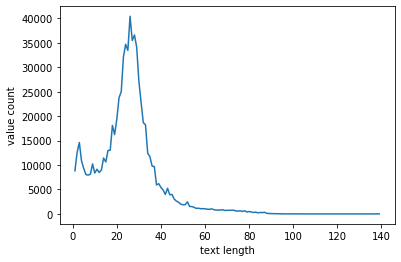

In [110]:
a,b = zip(*sorted([(tl,cnt) for tl,cnt in text_len.value_counts().iteritems()]))
plt.plot(a,b)
plt.xlabel('text length')
plt.ylabel('value count')
plt.show()

In [111]:
np.percentile(text_len,99)

72.0

In [112]:
cut1 = 2
cut2 = 100
print('lower cut removes {:.2f}% of dataset'.format(np.mean((text_len<=cut1)*100)))
print('upper cut removes {:.2f}% of dataset'.format(np.mean((text_len>cut2)*100)))

lower cut removes 2.90% of dataset
upper cut removes 0.01% of dataset


In [113]:
df = df[text_len>cut1]

# TEST TRAIN SPLIT (FAIR)

In [114]:
# uniform split within each label

In [115]:
test_split = 0.2
df['train/test']='train'
too_small = []
test_inds = np.array([])
sic_set = set(df.sic.values)
for s,sic in enumerate(sic_set):
    inds = df.index[df['sic']==sic].values
    if len(inds)<=1:
        too_small = too_small + inds
    else:
        split = int(len(inds)*test_split)
        np.random.seed(s)
        np.random.shuffle(inds)
        test_inds = np.append(test_inds,inds[:max(1,split)])
    if s%(len(sic_set)//10)==0:
        print("{:.0f}%".format((s+1)/len(sic_set)*100),end='\r')
df.loc[test_inds,'train/test']='test'

In [117]:
print(too_small)

[]


In [116]:
df.loc[test_inds,'train/test']='test'

In [118]:
df.head()

,text,categories,train/test,sic,cat0,cat1,cat2,cat3,hierarchy
id,,,,,,,,,
453844,welcome to a1 lifts . professional and reliabl...,"[C, 33, 3319, 33190]",train,33190,[C],[33],[3319],[33190],[C33190]
914843,"our friendly service , surprising range of fre...","[G, 47, 4711, 47110]",train,47110,[G],[47],[4711],[47110],[G47110]
326959,"wherever you want to get to in life , lloyds b...","[K, 64, 6419, 64191]",train,64191,[K],[64],[6419],[64191],[K64191]
541943,stanley gibbons – the home of stamp collecting...,"[G, 47, 4778, 47789]",test,47789,[G],[47],[4778],[47789],[G47789]
445157,are you looking for high-quality dentistry in ...,"[Q, 86, 8623, 86230]",train,86230,[Q],[86],[8623],[86230],[Q86230]


In [119]:
dd_train = {key:val for key,val in df[df['train/test']=='train'].sic.value_counts().iteritems()}
dd_test = {key:val for key,val in df[df['train/test']=='test'].sic.value_counts().iteritems()}
train_count = []
test_count= []
for key,val in df.sic.value_counts().iteritems():
    train_count.append(dd_train[key])
    test_count.append(dd_test[key])    

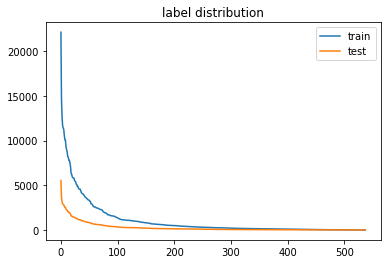

In [120]:
plt.plot(train_count,label='train')
plt.plot(test_count,label='test')
plt.title('label distribution')
plt.legend()
plt.show()

In [121]:
df.to_pickle('data/sic_hierarchy.pkl')

In [126]:
[n for n in df.columns if n.startswith('cat')]

['categories', 'cat0', 'cat1', 'cat2', 'cat3']

# SOME STATS

In [56]:
train_len = df[df['train/test']=='train']['text'].apply(lambda x:len(x.split(' '))).values

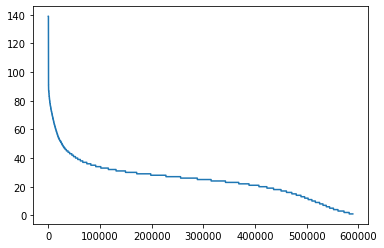

In [58]:
plt.plot(sorted(train_len,reverse = True))

In [94]:
a = [1,2,3,4]
a[:10]

[1, 2, 3, 4]